Generating frames...


Создание generated_sequence.mp4: 100%|██████████| 240/240 [00:01<00:00, 176.42it/s]


Tracking objects...


Создание tracking_results.mp4: 100%|██████████| 240/240 [00:01<00:00, 148.55it/s]


Visualizing results...


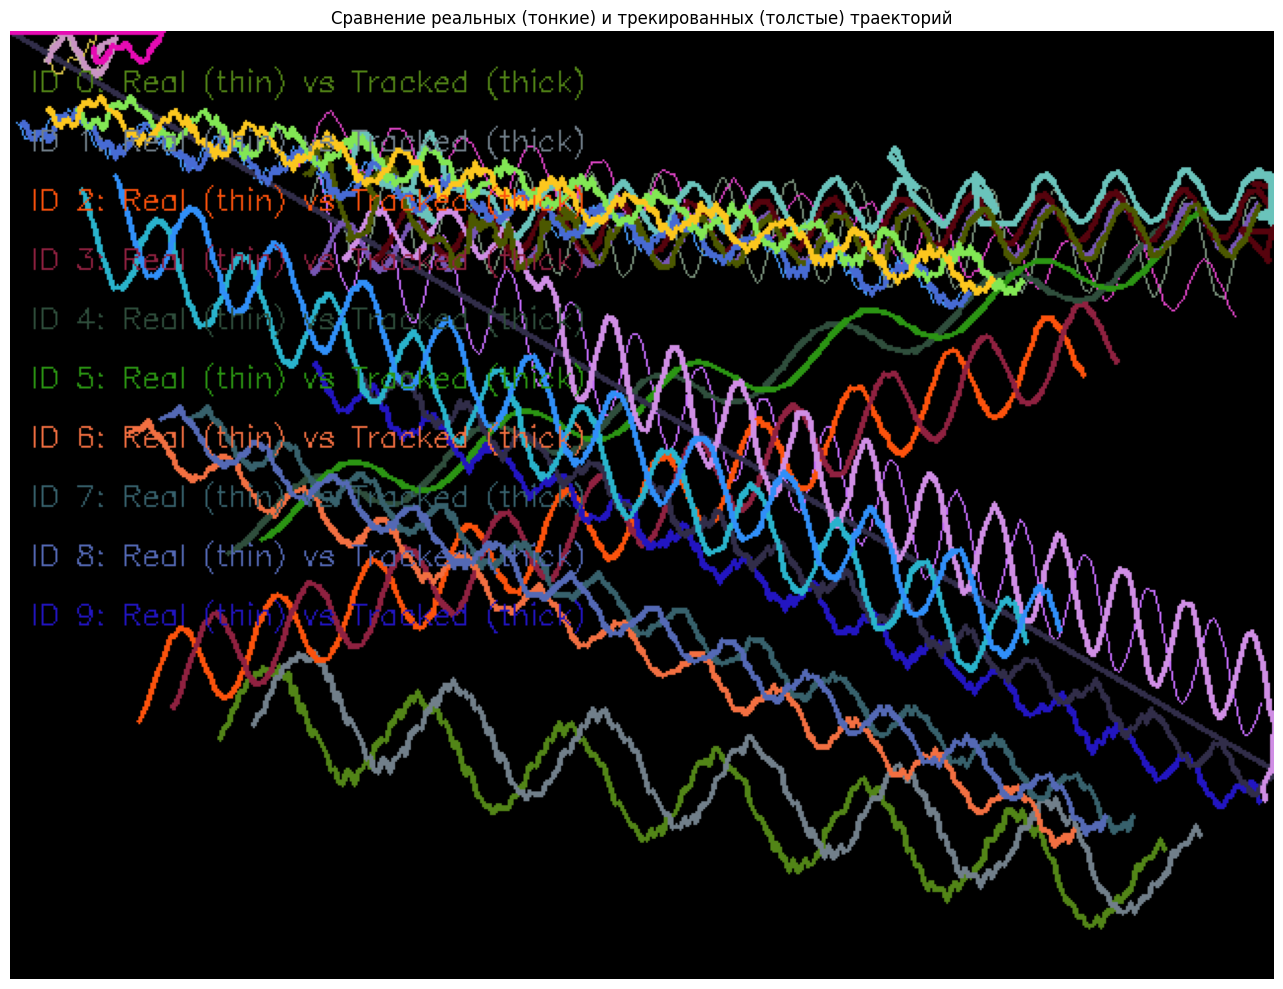

Processing completed. Results in task6 folder:
- generated_sequence.mp4 - original sequence
- tracking_results.mp4 - tracking results
- tracking_comparison*.png - trajectory comparison
- trajectories.txt - object coordinates


In [3]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import glob

# Create all necessary directories
os.makedirs('/content/sample_data/back', exist_ok=True)
os.makedirs('/content/sample_data/cells', exist_ok=True)
os.makedirs('task6/frames', exist_ok=True)
os.makedirs('task6/tracking_results', exist_ok=True)

WIDTH, HEIGHT = 640, 480
FPS = 24
DURATION = 10  # seconds
TOTAL_FRAMES = FPS * DURATION
NUM_CELLS = 15
COLORS = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(NUM_CELLS)]

class Cell:
    def __init__(self, cell_id):
        self.id = cell_id
        self.color = COLORS[cell_id]
        self.x = random.randint(0, WIDTH//4)
        self.y = random.randint(0, HEIGHT)
        self.a = random.uniform(-0.5, 0.5)
        self.b = random.randint(0, HEIGHT)
        self.c = random.uniform(5, 30)
        self.omega = random.uniform(0.05, 0.2)
        self.noise = random.uniform(0, 5)
        self.active = True
        self.trajectory = []

    def update_position(self, t):
        if not self.active:
            return False

        self.x += 2
        noise = random.uniform(-self.noise, self.noise)
        self.y = self.a * self.x + self.b + self.c * np.sin(self.omega * self.x) + noise

        if self.x < 0 or self.x >= WIDTH or self.y < 0 or self.y >= HEIGHT:
            self.active = False
            return False

        self.trajectory.append((self.x, self.y))
        return True

def generate_frames():
    cells = [Cell(i) for i in range(NUM_CELLS)]
    active_cells = NUM_CELLS

    for frame_idx in tqdm(range(TOTAL_FRAMES), desc="Generating frames"):
        frame = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)

        for cell in cells:
            if cell.active:
                if not cell.update_position(frame_idx / FPS):
                    active_cells -= 1

        # Draw trajectories
        for cell in cells:
            if len(cell.trajectory) > 1:
                for i in range(1, len(cell.trajectory)):
                    cv2.line(frame,
                            (int(cell.trajectory[i-1][0]), int(cell.trajectory[i-1][1])),
                            (int(cell.trajectory[i][0]), int(cell.trajectory[i][1])),
                            cell.color, 1)

        # Draw cells
        for cell in cells:
            if cell.active:
                cv2.circle(frame, (int(cell.x), int(cell.y)), 8, cell.color, -1)
                cv2.putText(frame, str(cell.id), (int(cell.x)+10, int(cell.y)),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.imwrite(f'task6/frames/frame_{frame_idx:04d}.png', frame)

        if active_cells <= 0:
            break

    return cells

def track_objects():
    tracker = cv2.legacy.MultiTracker_create()
    frame_files = sorted(glob.glob('task6/frames/frame_*.png'))

    if not frame_files:
        raise FileNotFoundError("No frames found in task6/frames/ directory. Please generate frames first.")

    trajectories = defaultdict(list)

    # Initialize with first frame
    first_frame = cv2.imread(frame_files[0])
    if first_frame is None:
        raise ValueError("Failed to read first frame")

    gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Generate colors for tracking
    tracking_colors = []
    bboxes = []
    for i, cnt in enumerate(contours):
        if cv2.contourArea(cnt) > 20:
            tracking_colors.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
            x, y, w, h = cv2.boundingRect(cnt)
            bboxes.append((x, y, w, h))

    if not bboxes:
        raise ValueError("No objects detected in first frame")

    # Initialize trackers
    for bbox in bboxes:
        tracker.add(cv2.legacy.TrackerCSRT_create(), first_frame, bbox)

    # Process frames
    for frame_idx, frame_file in enumerate(tqdm(frame_files, desc="Tracking objects")):
        frame = cv2.imread(frame_file)
        if frame is None:
            continue

        success, boxes = tracker.update(frame)

        for i, box in enumerate(boxes):
            if i >= len(tracking_colors):
                continue

            x, y, w, h = box
            center = (int(x + w/2), int(y + h/2))
            trajectories[i].append(center)

            # Draw bounding box
            overlay = frame.copy()
            cv2.rectangle(overlay, (int(x), int(y)), (int(x + w), int(y + h)),
                         tracking_colors[i], 2)
            cv2.addWeighted(overlay, 0.5, frame, 0.5, 0, frame)

            # Draw ID and trajectory
            cv2.putText(frame, f"ID:{i}", (int(x), int(y)-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, tracking_colors[i], 2)

            if len(trajectories[i]) > 1:
                for j in range(1, len(trajectories[i])):
                    cv2.line(frame, trajectories[i][j-1], trajectories[i][j],
                            tracking_colors[i], 2)

        cv2.imwrite(frame_file.replace('frames', 'tracking_results'), frame)

    return trajectories, tracking_colors

# [Rest of the functions remain the same]

if __name__ == "__main__":
    try:
        # Generate data
        print("Generating frames...")
        generated_cells = generate_frames()
        create_video('task6/frames/frame_*.png', 'generated_sequence')

        # Tracking
        print("Tracking objects...")
        trajectories, tracking_colors = track_objects()
        create_video('task6/tracking_results/frame_*.png', 'tracking_results')

        # Visualization
        print("Visualizing results...")
        visualize_results(trajectories, generated_cells, tracking_colors)

        # Save trajectories
        with open('task6/trajectories.txt', 'w') as f:
            for obj_id, points in trajectories.items():
                f.write(f"Object {obj_id}:\n")
                for point in points:
                    f.write(f"{point[0]}, {point[1]}\n")
                f.write("\n")

        print("Processing completed. Results in task6 folder:")
        print("- generated_sequence.mp4 - original sequence")
        print("- tracking_results.mp4 - tracking results")
        print("- tracking_comparison*.png - trajectory comparison")
        print("- trajectories.txt - object coordinates")

    except Exception as e:
        print(f"Error occurred: {str(e)}")